## Extract not just near-miss but all approach/retreat segments that are at least 3 TRs long

In [1]:
import numpy as np
import pandas as pd

from os.path import join, exists, isfile 

import nilearn as nil
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_glass_brain

from src.preprocess.stim_times import *
import pickle

def getSelectedStims(line):
    """
    Parameter
    ---------
    line: single line of strings that consist of multiple stim onsets and durations.
            For example: "2.20:8.97 15.50:7.25 30.00:6.36\n"
    
    Returns
    -------
    tuple of numpy.1darray
        sel_onsets, sel_durs: those onsets which have duration greater then 3.75 seconds.
    """
    onsets = np.array([float(onset) for onset,_ in [pair.split(':') for pair in line.split()]])
    durs = np.array([float(dur) for _,dur in [pair.split(':') for pair in line.split()]])
    sel_onsets = onsets[durs>=3.75]
    sel_durs = durs[durs>=3.75]
    return sel_onsets, sel_durs


def tmp_df(subj,seg,label=None):
    '''
    Parameters
    ----------
    subj: subj ID <str>
    seg: current run's appraoch/retreat sequence <(time x feature) numpy.array>
    label: 1. (approach) or 0. (retreat) <float>
    
    Returns
    -------
    tmp_df: pd.Dataframe with columns: Subject, timepoint,feat_# and label
    '''
    n_vox = seg[0].shape[1]
    features = ['feat_%i'%ii for ii in range(n_vox)]
    df = pd.DataFrame(columns=['Subject','timepoint']+features+['y'])
    for seq in seg:
        tmp_df = pd.DataFrame(seq,columns=features)
        tmp_df['Subject'] = subj
        tmp_df['TimePoint'] = np.arange(seq.shape[0])
        tmp_df['y'] = label
        df = pd.concat([df,tmp_df],axis=0,ignore_index=True)
    
    return df

In [2]:
# Project path
raw_path = '/home/climbach/approach-retreat/data/raw'
processed_path = '/home/climbach/approach-retreat/data/processed'

yoked = pd.read_excel(join(raw_path,'CON_yoked_table.xlsx'))
yoked = yoked.query('use == 1')

run_vars = ['run%s' % i for i in range(6)]
control = yoked[['control'] + run_vars]
uncontrol = yoked[['uncontrol'] + run_vars]

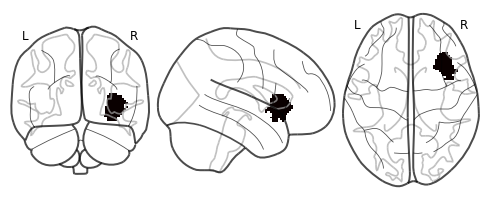

In [3]:
## Load right ventro-anterior insula mask 
mask= nil.image.load_img(join(processed_path,'masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz'))
rvAI = np.zeros_like(mask.get_fdata())
rvAI[np.logical_or(mask.get_fdata() == 230,mask.get_fdata() == 231)] = 1
rvAI = nil.image.new_img_like(mask,rvAI)

plot_glass_brain(rvAI)

In [4]:
# Path to approach timings
appr_file_path = join(raw_path,'{subj}/splitted_regs_fancy/{subj}_closeAllApprMR.txt')
# Path to retreat timings
retr_file_path = join(raw_path,'{subj}/splitted_regs_fancy/{subj}_closeAllRetrMR.txt')
# Path to experimental proximity values
proximity_path = join(raw_path,'{subj}/regs_fancy/{subj}_all_regs.txt')

# Define path to the shock beta map of every subject
func_path = join(raw_path,'{subj}/{subj}_EP_TR_MNI_2mm_SI_denoised_NoBaseline.nii.gz')

In [5]:
mean_TS = []
main_df = pd.DataFrame()
for _, row in yoked.iterrows():
    run_list = np.arange(6)[row.loc['run0':'run5'].astype(bool)]
    nruns = len(run_list)
    subj=row['uncontrol']
    print(subj)
    
    # loading whole-brain timeseries data
    func = nil.image.load_img(func_path.format(subj=subj))
    # Extract time-series only from right ventral-anterior insula 
    rvAI_ts = apply_mask(func,rvAI)
    del func

    # Split timeseries into runs and z-scoring with subject, run, amd voxel
    runs = [(X - X.mean(axis=0))/X.std(axis=0) for X in np.split(rvAI_ts,nruns,axis=0)]

    mean_TS = np.vstack(runs).mean(axis=0)

    # Reading the proximity regressor and splitting it into runs
    prox = np.split(pd.read_csv(proximity_path.format(subj=subj),sep='\t',index_col=0).iloc[:,0].values, nruns,axis=0)
    
    # Reading the approach and retreat onset-duration files
    approach_file = open(appr_file_path.format(subj=subj),'r').readlines()
    retreat_file = open(retr_file_path.format(subj=subj),'r').readlines()

    for n in range(len(runs)):
        print('run: ',n+1)
        # Get approach onsets and corresponding durations
        appr_onset, appr_dur = getSelectedStims(approach_file[n])
        # Compute approach offsets
        appr_offset = appr_onset + appr_dur

        # Get indices for approach onsets and offsets
        _, appr_onset_idx = return_closest_TR(appr_onset)
        _, appr_offset_idx = return_closest_TR(appr_offset)

        # Get retreat onsets and corresponding durations
        retr_onset, retr_dur = getSelectedStims(retreat_file[n])
        # Compute retreat offset
        retr_offset = retr_onset + retr_dur

        # Get indices for retreat onsets and offsets
        _, retr_onset_idx = return_closest_TR(retr_onset)
        _, retr_offset_idx = return_closest_TR(retr_offset)

        # Extract the approach and retreat segments
        appr = [rvAI_ts[onset+3:offset+3,:] for onset, offset in zip(appr_onset_idx,appr_offset_idx)]
        retr = [rvAI_ts[onset+3:offset+3,:] for onset, offset in zip(retr_onset_idx,retr_offset_idx)]
        
        # Ensure that approach and retreat sequences are not the same
        np.testing.assert_raises(AssertionError, np.testing.assert_array_equal,np.vstack(appr),np.vstack(retr))

        tmp_df_appr = tmp_df(subj,appr,1.)
        tmp_df_retr = tmp_df(subj,retr,0.)
        features = [col for col in tmp_df_appr.columns if 'feat' in col]
        
        # Ensure that approach and retreat sequence dataframes are not the same
        np.testing.assert_raises(AssertionError,pd.testing.assert_frame_equal,tmp_df_appr[features],tmp_df_retr[features])

        main_df = pd.concat([main_df,tmp_df_appr,tmp_df_retr],ignore_index=True,axis=0)
        

with open('../../data/processed/04a-rvAI_ALL_appr_retr_normWithinSeg.pkl',"wb") as f:
    pickle.dump(main_df,f)

CON031
run:  1
run:  2
run:  3
run:  4
run:  5
CON021
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON022
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON030
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON023
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON025
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON016
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON053
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON052
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON089
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON020
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON033
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON019
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON084
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON027
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON049
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON028
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON026
run:  1
run:  2
run:  3
run:  4
run:  5
run:  6
CON054
run:  1
run

In [9]:
main_df

,Subject,timepoint,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,...,feat_736,feat_737,feat_738,feat_739,feat_740,feat_741,feat_742,feat_743,feat_744,y
0,CON031,0,0.528931,0.487457,0.232246,0.148743,0.042282,-0.305954,0.569565,0.028038,...,-0.865524,-0.758942,0.071503,1.118309,0.560417,-0.223091,0.608696,0.765785,-0.022957,1.0
1,CON031,1,-0.277634,0.348404,0.026642,-0.086540,0.005081,0.122566,1.775352,-0.345436,...,-0.067467,-0.640572,-0.660301,0.037865,0.219612,-0.212631,-0.141502,-1.459686,-0.079445,1.0
2,CON031,2,-0.340950,-0.046494,-0.843697,0.386253,-0.055161,0.201759,0.193954,-0.822807,...,-1.271828,-0.418358,0.326378,0.542999,0.977371,1.462898,1.349091,0.401657,-0.616539,1.0
3,CON031,3,-0.957230,-0.483696,-0.631943,-0.733025,-1.054535,-1.221367,0.300766,-0.171844,...,0.446693,0.161339,0.489334,1.113060,2.073517,1.702499,1.946037,-0.957397,1.076385,1.0
4,CON031,4,0.653816,0.495163,-0.062981,0.620285,0.885437,0.156929,0.711739,0.269211,...,-0.830025,-0.618279,-0.234123,0.233643,0.618210,0.235153,0.525703,0.515823,0.627953,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82999,CON125,1,-0.283623,-1.042488,-1.073769,0.454636,-0.201149,-0.231270,-0.983795,-1.283463,...,-1.001152,-1.333221,-1.543907,-1.423576,-0.959427,-0.876343,-1.070953,-1.029900,-0.504875,0.0
83000,CON125,2,0.260696,0.421593,0.127640,0.571007,0.909370,0.319832,-0.064583,1.000420,...,0.327415,0.189087,-0.191605,-0.078743,-0.718369,-1.648987,-2.553787,0.335281,1.078712,0.0
83001,CON125,3,-0.413254,0.430389,-0.427307,-0.022545,-0.254982,-0.501038,0.454582,-0.002769,...,0.499496,0.793518,1.022598,1.292664,0.528244,0.425087,0.463249,0.378227,0.392067,0.0
83002,CON125,4,1.657669,0.679832,1.421249,0.971809,1.133339,0.768166,-0.266853,1.040421,...,-0.882324,-0.767784,-0.819664,-0.628090,-1.238991,-1.311623,-0.403946,-0.219124,-0.495201,0.0
